In [1]:
import gurobipy as gp
from gurobipy import GRB
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import warnings
from tqdm import tqdm_notebook as tqdm
import requests
import json
import API
import matplotlib.pyplot as plt
import GoogleDistanceMatrix
import GoogleVRP
import routing
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

# Current shared

In [103]:
order = pd.read_excel('../1. Sales Data/DMS order_2-6Nov2020 (Only store with DMS available)+Transportation.xlsx')
order = order.loc[order['Instant Order']==True]
store = pd.read_csv('Data/StoreLocation.csv')

In [104]:
order['orderTime'] = pd.to_datetime(order['下單時間'])
order['arrivalTime'] = pd.to_datetime(order['訂單送達時間'])
order['departureTime'] = pd.to_datetime(order['取餐出發時間'])

order['waitingTime'] = order['arrivalTime'] - order['orderTime']
order['tripDurationReal'] = pd.to_datetime(order['訂單送達時間']) - pd.to_datetime(order['departureTime'])
order['tripDurationReal'] = order['tripDurationReal'].dt.seconds

In [105]:
order.shape

(505, 20)

In [106]:
order['waitingTime'].describe()

count                       505
mean     0 days 00:36:08.730693
std      0 days 00:12:27.626481
min             0 days 00:16:02
25%             0 days 00:27:42
50%             0 days 00:33:46
75%             0 days 00:41:05
max             0 days 01:33:23
Name: waitingTime, dtype: object

In [107]:
order = order.sort_values(by=['取餐出發時間','Rider'])
order['last取餐出發時間'] = order['取餐出發時間'].shift(1)
order['lastRider'] = order['Rider'].shift(1)
order['pre取餐出發時間'] = order['取餐出發時間'].shift(-1)
order['preRider'] = order['Rider'].shift(-1)

In [108]:

shared = order.loc[((order['last取餐出發時間']==order['取餐出發時間'])&(order['lastRider']==order['Rider']))|
                   ((order['pre取餐出發時間']==order['取餐出發時間'])&(order['preRider']==order['Rider']))]
single = order.loc[((order['last取餐出發時間']!=order['取餐出發時間'])|(order['lastRider']!=order['Rider']))|
                   ((order['pre取餐出發時間']!=order['取餐出發時間'])|(order['preRider']!=order['Rider']))]

In [109]:
order.shape

(505, 24)

In [110]:
shared.shape

(140, 24)

In [114]:
order.loc[order['Rider']=='3rdParty'].shape

(13, 24)

In [240]:
shared['waitingTime'].describe()

count                       138
mean     0 days 00:42:49.384057
std      0 days 00:14:43.388014
min             0 days 00:20:14
25%      0 days 00:33:24.250000
50%      0 days 00:39:02.500000
75%      0 days 00:47:22.500000
max             0 days 01:33:23
Name: waitingTime, dtype: object

In [241]:
single['waitingTime'].describe()

count                       499
mean     0 days 00:36:01.466933
std      0 days 00:12:18.852885
min             0 days 00:16:02
25%      0 days 00:27:39.500000
50%             0 days 00:33:43
75%             0 days 00:40:49
max             0 days 01:33:23
Name: waitingTime, dtype: object

## data preprocessing

In [ ]:
def get_lat_lon(x):
    location = x['配送地址']
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=香港'+location+'&key='+API.key
    data = requests.get(url)
    text = json.loads(data.text)
    if text['results'] == []:
        return('missing')
    lat = str(text['results'][0]['geometry']['location']['lat'])
    lng = str(text['results'][0]['geometry']['location']['lng'])
    return(lat+','+lng)

In [ ]:
order['DeliveryLatLon'] = order.apply(get_lat_lon,axis=1)

In [4]:
def tripDurationFromGoogle(x):
    StoreLatLon,DeliveryLatLon = x['StoreLatLon'],x['DeliveryLatLon']
    url = 'https://maps.googleapis.com/maps/api/directions/json?origin='+StoreLatLon+\
    '&destination='+DeliveryLatLon+'&mode=driving&key='+API.key
    data = requests.get(url)
    text = json.loads(data.text)
    if text['routes'] == []:
        return 'missing'
         
    else:
        duration = text['routes'][0]['legs'][0]['duration']['value']
        return duration

In [ ]:
order = order[['日期', '門店名稱', '配送地址', '下單時間', '指派成功時間', '騎手接單時間', '到店取餐時間', '取餐出發時間',
       '訂單送達時間', '預送達時間', 'Banner', 'Instant Order', '收貨地址坐標', 'Rider',
       'Transportation', 'orderTime', 'arrivalTime', 'waitingTime',
       'last取餐出發時間', 'lastRider', 'departureTime', 'tripDurationReal',
       'DeliveryLatLon']]

In [85]:
order = order.merge(store, how='left',left_on='門店名稱', right_on='storeCode')
order['StoreLatLon'] = order['lat'].astype(str)+','+order['lon'].astype(str)

In [131]:
order['tripDurationFromGoogle'] = order.apply(lambda x:tripDurationFromGoogle(x),axis=1)

In [150]:
order = order.loc[order['tripDurationFromGoogle']!='missing']
order['tripDurationFromGoogle'] = order['tripDurationFromGoogle'].astype(int)

In [242]:
order['shared'] = 0
order.loc[((order['last取餐出發時間']==order['取餐出發時間'])&(order['lastRider']==order['Rider']))|
                   ((order['pre取餐出發時間']==order['取餐出發時間'])&(order['preRider']==order['Rider'])),'shared'] = 1

In [269]:
order.loc[order['shared']==0]['tripDurationFromGoogle'].mean()/60

7.692191780821918

In [270]:
order.loc[order['shared']==0]['tripDurationReal'].mean()/60

15.16579908675799

In [271]:
timeParameter = (order['tripDurationReal']/60).mean() / (order['tripDurationFromGoogle']/60).mean()
timeParameter

2.142449731214544

In [211]:
order['foodPreparationTime'] = pd.to_datetime(order['取餐出發時間']) - pd.to_datetime(order['下單時間'])

In [212]:
order.loc[order['shared']==0]['foodPreparationTime'].mean()

Timedelta('0 days 00:19:12.092592')

In [213]:
order.loc[order['shared']==1]['foodPreparationTime'].mean()

Timedelta('0 days 00:24:21.577464')

In [243]:
order.to_csv('Data/ProcessedNov.csv',index=False)

## modelling

In [69]:
order = pd.read_csv('Data/ProcessedNov.csv')

In [70]:
order.shape

(503, 32)

In [71]:
order['門店名稱'].unique()

array(['PH64', 'PH57', 'PHD629', 'PHD606'], dtype=object)

In [72]:
order = order.loc[order['門店名稱'].isin(['PH57','PHD629'])]
order.shape

(309, 32)

In [73]:
order['shared'] = 0
order.loc[(((pd.to_datetime(order['取餐出發時間'])-pd.to_datetime(order['last取餐出發時間'])).dt.seconds<5)&
           (order['lastRider']==order['Rider']))|
        (((pd.to_datetime(order['取餐出發時間'])-pd.to_datetime(order['pre取餐出發時間'])).dt.seconds<5)&
         (order['preRider']==order['Rider'])),'shared'] = 1

In [74]:
order.loc[order['Rider']=='3rdParty'].shape

(6, 32)

In [75]:
order['foodPreparationTime'] = pd.to_datetime(order['取餐出發時間']) - pd.to_datetime(order['下單時間'])

In [76]:
order.loc[order['shared']==0]['foodPreparationTime'].mean()

Timedelta('0 days 00:19:01.794736')

In [77]:
order.loc[order['shared']==1]['foodPreparationTime'].mean()

Timedelta('0 days 00:24:36.739495')

In [78]:
order.loc[order['shared']==1].shape

(119, 32)

In [81]:
(order['tripDurationReal'] < 60).sum()

8

In [82]:
(pd.to_timedelta(order['waitingTime']).dt.seconds>3000).sum()

43

order = order.loc[order['tripDurationReal']>=order['tripDurationFromGoogle']]

In [83]:
pd.to_timedelta(order['waitingTime']).mean()

Timedelta('0 days 00:38:20.867313')

In [85]:
from scipy import stats
stats.ttest_ind(order.loc[order['shared']==0]['foodPreparationTime'].dt.seconds,
                order.loc[order['shared']==1]['foodPreparationTime'].dt.seconds)

Ttest_indResult(statistic=-4.73728891975688, pvalue=3.3158725284262513e-06)

In [86]:
order = order[['orderTime', 'arrivalTime', 'foodPreparationTime','waitingTime', 'departureTime', 'tripDurationReal',
       'DeliveryLatLon', 'storeCode', 'StoreLatLon',
       'tripDurationFromGoogle', 'shared']]

In [87]:
order['departureTime'] = pd.to_datetime(order['departureTime'])
order['hour'] = order['departureTime'].dt.hour
order['min'] = order['departureTime'].dt.minute
order['min'] = order['min'].apply(lambda x: (int(x/5)+1)*5)

In [88]:
order['timeWindow'] = pd.Timedelta('0 days 00:50:00') - order['foodPreparationTime']
order['timeWindow'] = order['timeWindow'].dt.seconds
# order['timeWindow']

In [89]:
(order['timeWindow'] < order['tripDurationReal']).sum()

37

In [90]:
order.tripDurationReal.describe()

count     309.000000
mean     1030.080906
std       606.319750
min         2.000000
25%       626.000000
50%       913.000000
75%      1377.000000
max      5509.000000
Name: tripDurationReal, dtype: float64

In [91]:
order['timeParameter'] = order['tripDurationReal']/order['tripDurationFromGoogle']
order['timeParameter'] = order['timeParameter'].median()
# timeParameter = order.groupby(['hour','min','shared']).agg({'timeParameter':'min'}).reset_index()
# timeParameter = timeParameter.loc[timeParameter['shared']==0]
# del timeParameter['shared']
# del order['timeParameter']

In [92]:
order['timeParameter'].median()

1.9877551020408164

In [93]:
order.sort_values(by=['timeParameter'])

,orderTime,arrivalTime,foodPreparationTime,waitingTime,departureTime,tripDurationReal,DeliveryLatLon,storeCode,StoreLatLon,tripDurationFromGoogle,shared,hour,min,timeWindow,timeParameter
1,2020-11-02 12:10:00,2020-11-02 12:32:40,00:14:18,0 days 00:22:40.000000000,2020-11-02 12:24:18,502,"22.4628057,114.0054404",PH57,"22.469012,114.002131",416,0,12,25,2142,1.987755
320,2020-11-05 18:11:00,2020-11-05 19:07:57,00:24:23,0 days 00:56:57.000000000,2020-11-05 18:35:23,1954,"22.4512595,114.0012607",PH57,"22.469012,114.002131",690,1,18,40,1537,1.987755
319,2020-11-05 17:55:00,2020-11-05 18:35:06,00:39:58,0 days 00:40:06.000000000,2020-11-05 18:34:58,8,"22.4612642,114.0061941",PH57,"22.469012,114.002131",537,1,18,35,602,1.987755
318,2020-11-05 18:06:00,2020-11-05 18:44:31,00:28:58,0 days 00:38:31.000000000,2020-11-05 18:34:58,573,"22.4603182,114.0043947",PH57,"22.469012,114.002131",465,1,18,35,1262,1.987755
317,2020-11-05 18:13:00,2020-11-05 18:48:44,00:19:22,0 days 00:35:44.000000000,2020-11-05 18:32:22,982,"22.4479376,114.0014584",PH57,"22.469012,114.002131",715,0,18,35,1838,1.987755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2020-11-03 18:37:00,2020-11-03 19:07:07,00:22:52,0 days 00:30:07.000000000,2020-11-03 18:59:52,435,"22.450921,113.99002",PH57,"22.469012,114.002131",660,0,18,60,1628,1.987755
147,2020-11-03 18:27:00,2020-11-03 18:58:06,00:24:00,0 days 00:31:06.000000000,2020-11-03 18:51:00,426,"22.4662962,113.9995999",PH57,"22.469012,114.002131",293,1,18,55,1560,1.987755
146,2020-11-03 18:36:00,2020-11-03 19:03:24,00:15:00,0 days 00:27:24.000000000,2020-11-03 18:51:00,744,"22.4666015,113.9998786",PH57,"22.469012,114.002131",309,1,18,55,2100,1.987755
154,2020-11-03 18:55:00,2020-11-03 19:26:52,00:22:43,0 days 00:31:52.000000000,2020-11-03 19:17:43,549,"22.4489561,114.0010867",PHD629,"22.456107199999998,113.99848390000001",439,1,19,20,1637,1.987755


In [94]:
order['timeWindow'] = order['timeWindow'] /order['timeParameter']
order.loc[order['timeWindow'] < order['tripDurationFromGoogle'],'timeWindow'] = \
order.loc[order['timeWindow'] < order['tripDurationFromGoogle'],'tripDurationFromGoogle']

In [95]:
rider_df = pd.read_excel('../1. Sales Data/2-6Nov - Clock in record.xls')
rider_df['Clock in.1'] = pd.to_datetime(rider_df['Clock in.1'])
rider_df['Date'] = rider_df['Clock in.1'].dt.day

In [97]:
PHDLatLon = order.loc[order['storeCode']=='PHD629']['StoreLatLon'].values[0]
PHLatLon = order.loc[order['storeCode']=='PH57']['StoreLatLon'].values[0]


In [98]:
order['tripTime'] = 0
order['rider'] = 0

In [99]:
PHD_output = pd.DataFrame()
PH_output = pd.DataFrame()

In [100]:
order.tripDurationReal.describe()

count     309.000000
mean     1030.080906
std       606.319750
min         2.000000
25%       626.000000
50%       913.000000
75%      1377.000000
max      5509.000000
Name: tripDurationReal, dtype: float64

In [101]:
order['tripTime'] = 0
order['rider'] = 0
order['delayed'] = 0
order['departureTimeSimulation'] = pd.to_datetime(order.orderTime).dt.date.astype(str)+' '+order['hour'].apply(lambda x:str(x).zfill(2))+\
                                        ':'+order['min'].apply(lambda x:str(x).zfill(2))+':00'
PHD_output = pd.DataFrame()
PH_output = pd.DataFrame()

In [ ]:
for day in range(2,7):
    # reset riders
    riders = rider_df.loc[(rider_df['Rider Store Code'].isin([64,606]))&(rider_df['Date']==day)]['Rider No.'].unique()
    riderStatus = {}
    for i in (riders):
        riderStatus[i] = 0
    for hour in range(11,24):
        for minute in np.arange(0,60,5):
            print(day,hour,minute)
            # update rider status at current time
            for key in riderStatus.keys():
                if riderStatus[key]!= 0:
                    if riderStatus[key] <= pd.to_datetime('2020-11-0%s %s:%s:00'%(day,hour,str(minute).zfill(2))):
                        riderStatus[key] = 0

            candidate = order.loc[(pd.to_datetime(order['orderTime']).dt.day==day)&(order['hour']==hour)&(order['min']==minute)]
            if len(candidate) > 0:
                PHD = candidate.loc[candidate['storeCode']=='PHD629']
                PH = candidate.loc[candidate['storeCode']=='PH57']
                timeParameter = order.loc[(order['hour']==hour)&(order['min']==minute)]['timeParameter'].unique()[0]
                print('PHD')
                PHD_output,riderStatus,order = routing.tripAssign(day,hour,minute,timeParameter,PHD, PHDLatLon, riderStatus,order,PHD_output)
                print('PH')
                PH_output,riderStatus,order = routing.tripAssign(day,hour,minute,timeParameter,PH, PHLatLon, riderStatus,order,PH_output)

                

In [ ]:
PH_output['arrivalTimeSimulation'] = pd.to_datetime(PH_output['departureTimeSimulation']) +\
                                        pd.to_timedelta(PH_output['tripTime'],'seconds')
PH_output['waitingTimeSimulation'] = PH_output['arrivalTimeSimulation'] - pd.to_datetime(PH_output['orderTime'])
PH_output['waitingTimeReal'] = pd.to_datetime(PH_output['arrivalTime']) - pd.to_datetime(PH_output['orderTime'])

In [32]:
PH_output['waitingTimeSimulation'].describe()

count                        85
mean     0 days 00:34:47.064954
std      0 days 00:09:49.937074
min             0 days 00:17:57
25%             0 days 00:28:06
50%             0 days 00:34:11
75%      0 days 00:39:44.660394
max      0 days 01:06:15.828951
Name: waitingTimeSimulation, dtype: object

In [33]:
PH_output['arrivalTimeSimulation'] = pd.to_datetime(PH_output['departureTimeSimulation']) +\
                                        pd.to_timedelta(PH_output['tripTime'],'seconds')
PH_output['waitingTimeSimulation'] = PH_output['arrivalTimeSimulation'] - pd.to_datetime(PH_output['orderTime'])
PH_output['waitingTimeReal'] = pd.to_datetime(PH_output['arrivalTime']) - pd.to_datetime(PH_output['orderTime'])

In [34]:
PH_output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:34:47.064954')

In [35]:
PH_output['waitingTimeReal'].mean()

Timedelta('0 days 00:33:59.152941')

<AxesSubplot:>

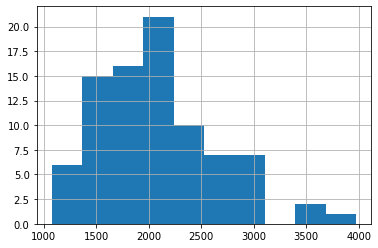

In [36]:
PH_output['waitingTimeSimulation'].dt.seconds.hist()

<AxesSubplot:>

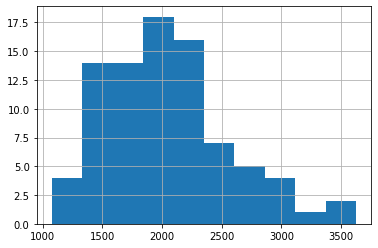

In [37]:
PH_output['waitingTimeReal'].dt.seconds.hist()

In [38]:

PHD_output['arrivalTimeSimulation'] = pd.to_datetime(PHD_output['departureTimeSimulation']) +\
                                        pd.to_timedelta(PHD_output['tripTime'],'seconds')
PHD_output['waitingTimeSimulation'] = PHD_output['arrivalTimeSimulation'] - pd.to_datetime(PHD_output['orderTime'])
PHD_output['waitingTimeReal'] = pd.to_datetime(PHD_output['arrivalTime']) - pd.to_datetime(PHD_output['orderTime'])

In [39]:
PHD_output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:32:06.705976')

In [40]:
PHD_output['waitingTimeReal'].mean()

Timedelta('0 days 00:31:55.919540')

In [41]:
pd.concat([PHD_output,PH_output]).to_csv('Output/order64_606_5min_TW.csv',index=False)

In [42]:
output = pd.concat([PHD_output,PH_output])

In [43]:
output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:33:25.953146')

In [44]:
(output['waitingTimeSimulation'].dt.seconds>3000).sum()

14

In [45]:
output.loc[output['waitingTimeSimulation'].dt.seconds>3000]

,orderTime,arrivalTime,foodPreparationTime,waitingTime,departureTime,tripDurationReal,DeliveryLatLon,storeCode,StoreLatLon,tripDurationFromGoogle,shared,hour,min,timeWindow,timeParameter,tripTime,rider,delayed,departureTimeSimulation,arrivalTimeSimulation,waitingTimeSimulation,waitingTimeReal
198,2020-11-04 13:51:00,2020-11-04 14:42:27,00:48:57,0 days 00:51:27.000000000,2020-11-04 14:39:57,150,"22.2872726,114.1501454",PHD606,"22.284361999999998,114.13979259999999",634,0,14,40,634.000000,1.984182,150.000000,11151127,0,2020-11-04 14:39:57,2020-11-04 14:42:27.000000000,00:51:27,00:51:27
389,2020-11-06 11:29:00,2020-11-06 12:25:21,00:20:06,0 days 00:56:21.000000000,2020-11-06 11:49:06,2175,"22.2746606,114.1742897",PHD606,"22.284361999999998,114.13979259999999",835,0,11,50,904.150982,1.984182,2175.000000,10797055,0,2020-11-06 11:49:06,2020-11-06 12:25:21.000000000,00:56:21,00:56:21
391,2020-11-06 11:30:00,2020-11-06 12:23:42,00:34:59,0 days 00:53:42.000000000,2020-11-06 12:04:59,1123,"22.2865433,114.1357141",PHD606,"22.284361999999998,114.13979259999999",354,0,12,5,454.091435,1.984182,1123.000000,10111612,0,2020-11-06 12:04:59,2020-11-06 12:23:42.000000000,00:53:42,00:53:42
392,2020-11-06 11:33:00,2020-11-06 12:34:10,00:51:01,0 days 01:01:10.000000000,2020-11-06 12:24:01,609,"22.2788412,114.1288841",PHD606,"22.284361999999998,114.13979259999999",321,0,12,25,43513.651978,1.984182,609.000000,30071279,0,2020-11-06 12:24:01,2020-11-06 12:34:10.000000000,01:01:10,01:01:10
393,2020-11-06 11:52:00,2020-11-06 12:48:47,00:40:43,0 days 00:56:47.000000000,2020-11-06 12:32:43,964,"22.2746457,114.1631178",PHD606,"22.284361999999998,114.13979259999999",660,0,12,35,660.000000,1.984182,964.000000,11151175,0,2020-11-06 12:32:43,2020-11-06 12:48:47.000000000,00:56:47,00:56:47
402,2020-11-06 11:53:00,2020-11-06 13:22:23,01:23:59,0 days 01:29:23.000000000,2020-11-06 13:16:59,324,"22.279945,114.1627109",PHD606,"22.284361999999998,114.13979259999999",583,0,13,20,42516.767561,1.984182,324.000000,11151158,0,2020-11-06 13:16:59,2020-11-06 13:22:23.000000000,01:29:23,01:29:23
483,2020-11-06 19:54:00,2020-11-06 20:49:34,00:55:34,0 days 00:55:34.000000000,2020-11-06 20:49:34,0,"22.2855698,114.1500525",PHD606,"22.284361999999998,114.13979259999999",567,0,20,50,43376.063785,1.984182,0.000000,10111612,0,2020-11-06 20:49:34,2020-11-06 20:49:34.000000000,00:55:34,00:55:34
60,2020-11-02 18:48:00,2020-11-02 19:25:10,00:36:54,0 days 00:37:10.000000000,2020-11-02 19:24:54,16,"22.2847577,114.1326485",PH64,"22.284392699999998,114.141973",487,1,19,25,487.000000,1.984182,1453.296578,11151158,0,2020-11-02 19:25:00,2020-11-02 19:49:13.296577947,01:01:13.296577,00:37:10
248,2020-11-04 19:03:00,2020-11-04 19:40:35,00:27:31,0 days 00:37:35.000000000,2020-11-04 19:30:31,604,"22.2766333,114.1547807",PH64,"22.284392699999998,114.141973",625,1,19,35,679.877188,1.984182,1159.729109,11151127,0,2020-11-04 19:35:00,2020-11-04 19:54:19.729108923,00:51:19.729108,00:37:35
250,2020-11-04 18:50:00,2020-11-04 19:50:27,00:41:09,0 days 01:00:27.000000000,2020-11-04 19:31:09,1158,"22.281696,114.124866",PH64,"22.284392699999998,114.141973",642,1,19,35,642.000000,1.984182,1275.828952,11151158,0,2020-11-04 19:35:00,2020-11-04 19:56:15.828951991,01:06:15.828951,01:00:27


In [46]:
output = output.sort_values(by=['departureTimeSimulation','rider'])
output['last取餐出發時間'] = output['departureTimeSimulation'].shift(1)
output['lastRider'] = output['rider'].shift(1)
output['pre取餐出發時間'] = output['departureTimeSimulation'].shift(-1)
output['preRider'] = output['rider'].shift(-1)
shared = output.loc[((output['last取餐出發時間']==output['departureTimeSimulation'])&(output['lastRider']==output['rider']))|
                   ((output['pre取餐出發時間']==output['departureTimeSimulation'])&(output['preRider']==output['rider']))]
single = output.loc[((output['last取餐出發時間']!=output['departureTimeSimulation'])|(output['lastRider']!=output['rider']))|
                   ((output['pre取餐出發時間']!=output['departureTimeSimulation'])|(output['preRider']!=output['rider']))]

In [47]:
shared.shape

(50, 26)

In [53]:
output.waitingTimeSimulation.mean()

Timedelta('0 days 00:33:25.953146')

In [68]:
output.groupby(['departureTimeSimulation','rider']).count().max()

orderTime                 2
arrivalTime               2
foodPreparationTime       2
waitingTime               2
departureTime             2
tripDurationReal          2
DeliveryLatLon            2
storeCode                 2
StoreLatLon               2
tripDurationFromGoogle    2
shared                    2
hour                      2
min                       2
timeWindow                2
timeParameter             2
tripTime                  2
delayed                   2
arrivalTimeSimulation     2
waitingTimeSimulation     2
waitingTimeReal           2
last取餐出發時間                2
lastRider                 2
pre取餐出發時間                 2
preRider                  2
dtype: int64